# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups               
Sample_152  P02533                          16.536
Sample_116  A0AVL1;F8WC54;Q13443;Q13443-2   15.406
Sample_051  P16083;Q5TD07                   14.174
Sample_011  A0A087X1J7;P22352               18.053
Sample_074  O95967                          17.919
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups            
Sample_198  A0A0J9YW36;Q9NZ72;Q9NZ72-2   13.477
Sample_002  O60565                       14.493
Sample_145  Q13332-5                     15.268
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.468
            A0A075B6Q5                 13.369
            A0A075B6R2                 12.032
            A0A075B6S5                 11.981
            A0A087WSY4                 13.699
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.162
            Q9UI40;Q9UI40-2            12.523
            Q9UIW2                     13.163
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.395
            Q9UP79                     12.332
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.229,15.050,16.842,19.863,15.575,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.170,19.067,...,15.528,15.576,14.062,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.547,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.420,17.705,17.039,16.193,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.874,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.501,15.345,17.084,18.708,14.249,19.433,11.787,11.025
Sample_207,15.739,16.877,15.469,16.898,15.676,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.880,13.370,13.295,13.350,12.868,12.301,12.683,12.699,13.022,12.494
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.703,19.067,16.127,...,13.172,12.499,11.631,11.948,12.518,12.240,13.680,13.411,12.835,12.452
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.496,12.938,12.540,12.218,11.551,13.007,11.708,12.069,12.594,12.301
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.546,11.973,13.531,12.131,12.165,12.963,12.623,12.628,13.055,11.464
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.523,12.506,12.884,12.664,13.184,13.339,13.816,12.229,13.498,12.986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.595,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 226.33it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.80it/s]

100%|██████████| 2/2 [00:00<00:00,  7.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.78it/s]

100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.16it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.18it/s]

100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  8.75it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.68it/s]

 80%|████████  | 4/5 [00:00<00:00,  5.13it/s]

100%|██████████| 5/5 [00:00<00:00,  4.80it/s]

100%|██████████| 5/5 [00:00<00:00,  5.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.99it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.09it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.71it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.41it/s]

100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  3.78it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.90it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.79it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.38it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.14it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.23it/s]

100%|██████████| 7/7 [00:02<00:00,  3.23it/s]

100%|██████████| 7/7 [00:02<00:00,  3.38it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.31it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.48it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.06it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.58it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.45it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.51it/s]

100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

100%|██████████| 8/8 [00:02<00:00,  3.67it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.91it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.88it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.25it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.49it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.48it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.36it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.49it/s]

100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  9.76it/s]

 30%|███       | 3/10 [00:00<00:01,  6.94it/s]

 40%|████      | 4/10 [00:00<00:01,  5.19it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.81it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.76it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.89it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.43it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.84it/s]

100%|██████████| 10/10 [00:02<00:00,  4.95it/s]

100%|██████████| 10/10 [00:02<00:00,  5.00it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.49it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.54it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.90it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.03it/s]

 55%|█████▍    | 6/11 [00:01<00:00,  5.30it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.26it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.72it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.50it/s]

 91%|█████████ | 10/11 [00:01<00:00,  4.53it/s]

100%|██████████| 11/11 [00:02<00:00,  4.37it/s]

100%|██████████| 11/11 [00:02<00:00,  4.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.43it/s]

 25%|██▌       | 3/12 [00:00<00:01,  7.43it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.38it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.85it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.61it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.54it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.48it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.54it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.67it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.63it/s]

100%|██████████| 12/12 [00:02<00:00,  4.44it/s]

100%|██████████| 12/12 [00:02<00:00,  4.84it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01, 10.60it/s]

 31%|███       | 4/13 [00:00<00:01,  5.48it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.91it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.62it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.62it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.15it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.49it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.45it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.17it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.03it/s]

100%|██████████| 13/13 [00:03<00:00,  3.01it/s]

100%|██████████| 13/13 [00:03<00:00,  3.75it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.36it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.12it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.42it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.05it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.89it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.83it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.94it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.22it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.35it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.67it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.72it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.80it/s]

100%|██████████| 14/14 [00:03<00:00,  3.89it/s]

100%|██████████| 14/14 [00:03<00:00,  3.56it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  8.11it/s]

 20%|██        | 3/15 [00:00<00:02,  5.47it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.78it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.99it/s]

 40%|████      | 6/15 [00:01<00:02,  3.42it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.24it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.27it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.15it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.21it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.26it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.50it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.79it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  4.03it/s]

100%|██████████| 15/15 [00:03<00:00,  4.20it/s]

100%|██████████| 15/15 [00:03<00:00,  3.82it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.050 0.020          0.801 0.316       0.132   
2             0.006 0.005      0.055 0.018          0.680 0.114       0.545   
3             0.004 0.003      0.039 0.010          0.699 0.095       0.628   
4             0.005 0.004      0.047 0.017          0.823 0.077       0.780   
5             0.005 0.005      0.051 0.020          0.823 0.074       0.786   
6             0.004 0.002      0.044 0.014          0.816 0.084       0.809   
7             0.008 0.009      0.074 0.033          0.814 0.083       0.813   
8             0.007 0.007      0.075 0.032          0.812 0.077       0.809   
9             0.004 0.001      0.041 0.014          0.813 0.085       0.815   
10            0.003 0.001      0.029 0.007          0.811 0.081       0.815   
11            0.004 0.000      0.039 0.013          0.810 0.081       0.812   
12            0.004 0.002      0.035 0.007          0.803 0.080       0.815   
13            0.005 0.005      0.048 0.018          0.813 0.081       0.804   
14            0.006 0.006      0.054 0.022          0.810 0.082       0.802   
15            0.004 0.000      0.042 0.017          0.808 0.083       0.802   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.220 0.128                  0.559 0.042        0.854   
2          0.109   0.597 0.087                  0.675 0.063        0.723   
3          0.131   0.651 0.087                  0.711 0.061        0.780   
4          0.109   0.796 0.070                  0.827 0.056        0.901   
5          0.114   0.798 0.071                  0.829 0.056        0.900   
6          0.115   0.807 0.072                  0.836 0.059        0.897   
7          0.109   0.808 0.069                  0.836 0.057        0.896   
8          0.109   0.805 0.067                  0.834 0.055        0.897   
9          0.104   0.809 0.068                  0.837 0.058        0.908   
10         0.100   0.809 0.068                  0.837 0.058        0.909   
11         0.109   0.806 0.072                  0.835 0.060        0.908   
12         0.101   0.805 0.067                  0.833 0.057        0.906   
13         0.100   0.804 0.071                  0.833 0.059        0.914   
14         0.098   0.802 0.069                  0.831 0.058        0.912   
15         0.097   0.801 0.067                  0.830 0.057        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.087        210.000 0.000  
2          0.080                  0.684 0.096        210.000 0.000  
3          0.081                  0.718 0.098        210.000 0.000  
4          0.048                  0.870 0.063        210.000 0.000  
5          0.048                  0.866 0.063        210.000 0.000  
6          0.047                  0.869 0.059        210.000 0.000  
7          0.048                  0.867 0.060        210.000 0.000  
8          0.047                  0.868 0.058        210.000 0.000  
9          0.048                  0.892 0.052        210.000 0.000  
10         0.047                  0.893 0.052        210.000 0.000  
11         0.048                  0.892 0.053        210.000 0.000  
12         0.048                  0.890 0.052        210.000 0.000  
13         0.047                  0.903 0.048        210.000 0.000  
14         0.048                  0.901 0.050        210.000 0.000  
15         0.048                  0.900 0.050 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 439.79it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.01it/s]

100%|██████████| 3/3 [00:00<00:00,  3.88it/s]

100%|██████████| 3/3 [00:00<00:00,  4.05it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.42it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.89it/s]

100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.43it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.81it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.06it/s]

100%|██████████| 5/5 [00:01<00:00,  2.90it/s]

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.46it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.46it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.65it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.18it/s]

100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

100%|██████████| 6/6 [00:01<00:00,  4.08it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00, 11.32it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  5.87it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  5.23it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.75it/s]

100%|██████████| 7/7 [00:01<00:00,  4.52it/s]

100%|██████████| 7/7 [00:01<00:00,  5.08it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.12it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.30it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.51it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.29it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.18it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.08it/s]

100%|██████████| 8/8 [00:01<00:00,  3.92it/s]

100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.38it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.11it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.91it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.65it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.77it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.88it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.83it/s]

100%|██████████| 9/9 [00:02<00:00,  3.84it/s]

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.42it/s]

 30%|███       | 3/10 [00:00<00:01,  4.52it/s]

 40%|████      | 4/10 [00:00<00:01,  3.75it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.57it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.32it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.39it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.54it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.85it/s]

100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

100%|██████████| 10/10 [00:02<00:00,  3.91it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00,  9.29it/s]

 27%|██▋       | 3/11 [00:00<00:01,  6.08it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.00it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.53it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.07it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.06it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.00it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.58it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.55it/s]

100%|██████████| 11/11 [00:02<00:00,  3.39it/s]

100%|██████████| 11/11 [00:02<00:00,  4.02it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.85it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.39it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.00it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.04it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.87it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.76it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.78it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.75it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.60it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.61it/s]

100%|██████████| 12/12 [00:03<00:00,  3.61it/s]

100%|██████████| 12/12 [00:03<00:00,  3.83it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.56it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.56it/s]

 31%|███       | 4/13 [00:01<00:02,  3.01it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.13it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.42it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.52it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.57it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.76it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.79it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.76it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.78it/s]

100%|██████████| 13/13 [00:03<00:00,  3.83it/s]

100%|██████████| 13/13 [00:03<00:00,  3.66it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.12it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.75it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.19it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.97it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.77it/s]

 50%|█████     | 7/14 [00:02<00:02,  3.10it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.09it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.23it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  3.39it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.45it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.44it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.50it/s]

100%|██████████| 14/14 [00:04<00:00,  3.58it/s]

100%|██████████| 14/14 [00:04<00:00,  3.38it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.93it/s]

 20%|██        | 3/15 [00:00<00:02,  5.44it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.70it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.26it/s]

 40%|████      | 6/15 [00:01<00:02,  4.10it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.86it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.02it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.57it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.08it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.78it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.67it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.68it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.80it/s]

100%|██████████| 15/15 [00:04<00:00,  2.97it/s]

100%|██████████| 15/15 [00:04<00:00,  3.38it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.037 0.005          0.000 0.000       0.000   
2             0.004 0.002      0.038 0.007          0.676 0.116       0.589   
3             0.005 0.005      0.057 0.022          0.776 0.100       0.695   
4             0.005 0.005      0.062 0.025          0.780 0.096       0.690   
5             0.005 0.004      0.044 0.017          0.770 0.101       0.703   
6             0.004 0.003      0.048 0.020          0.769 0.102       0.702   
7             0.004 0.003      0.044 0.016          0.775 0.104       0.710   
8             0.004 0.002      0.041 0.014          0.760 0.099       0.722   
9             0.004 0.002      0.040 0.012          0.768 0.095       0.732   
10            0.003 0.003      0.026 0.015          0.798 0.095       0.748   
11            0.004 0.000      0.035 0.001          0.822 0.099       0.771   
12            0.004 0.000      0.035 0.008          0.813 0.093       0.764   
13            0.005 0.005      0.043 0.022          0.813 0.091       0.781   
14            0.004 0.002      0.044 0.014          0.808 0.095       0.785   
15            0.004 0.001      0.038 0.010          0.825 0.087       0.801   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.846   
2          0.102   0.624 0.092                  0.689 0.071        0.781   
3          0.122   0.726 0.090                  0.772 0.071        0.867   
4          0.124   0.726 0.090                  0.772 0.071        0.872   
5          0.113   0.729 0.085                  0.772 0.069        0.876   
6          0.115   0.728 0.087                  0.772 0.071        0.874   
7          0.119   0.735 0.088                  0.777 0.071        0.874   
8          0.111   0.735 0.083                  0.775 0.069        0.884   
9          0.111   0.744 0.083                  0.783 0.068        0.883   
10         0.112   0.766 0.081                  0.802 0.066        0.910   
11         0.107   0.791 0.082                  0.822 0.066        0.919   
12         0.116   0.782 0.079                  0.815 0.065        0.919   
13         0.104   0.792 0.075                  0.822 0.064        0.922   
14         0.106   0.791 0.077                  0.822 0.065        0.923   
15         0.098   0.808 0.068                  0.836 0.059        0.927   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.819 0.089        210.000 0.000  
2          0.068                  0.730 0.100        210.000 0.000  
3          0.054                  0.844 0.068        210.000 0.000  
4          0.054                  0.849 0.062        210.000 0.000  
5          0.054                  0.856 0.061        210.000 0.000  
6          0.053                  0.854 0.060        210.000 0.000  
7          0.057                  0.852 0.066        210.000 0.000  
8          0.052                  0.867 0.059        210.000 0.000  
9          0.055                  0.864 0.061        210.000 0.000  
10         0.048                  0.890 0.056        210.000 0.000  
11         0.045                  0.902 0.053        210.000 0.000  
12         0.045                  0.903 0.051        210.000 0.000  
13         0.045                  0.905 0.050        210.000 0.000  
14         0.045                  0.907 0.049        210.000 0.000  
15         0.043                  0.912 0.046 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1180.83it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 36.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.59it/s]

100%|██████████| 3/3 [00:00<00:00, 17.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 21.28it/s]

100%|██████████| 4/4 [00:00<00:00, 18.84it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 17.88it/s]

100%|██████████| 5/5 [00:00<00:00, 14.26it/s]

100%|██████████| 5/5 [00:00<00:00, 14.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 24.17it/s]

100%|██████████| 6/6 [00:00<00:00, 16.78it/s]

100%|██████████| 6/6 [00:00<00:00, 17.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.20it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 16.17it/s]

100%|██████████| 7/7 [00:00<00:00, 14.70it/s]

100%|██████████| 7/7 [00:00<00:00, 15.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.95it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 20.11it/s]

100%|██████████| 8/8 [00:00<00:00, 19.10it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 21.85it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 16.02it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 15.65it/s]

100%|██████████| 9/9 [00:00<00:00, 16.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.94it/s]

 60%|██████    | 6/10 [00:00<00:00, 16.91it/s]

 80%|████████  | 8/10 [00:00<00:00, 16.56it/s]

100%|██████████| 10/10 [00:00<00:00, 16.91it/s]

100%|██████████| 10/10 [00:00<00:00, 17.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 21.65it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 15.52it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 14.51it/s]

 91%|█████████ | 10/11 [00:00<00:00, 14.31it/s]

100%|██████████| 11/11 [00:00<00:00, 14.78it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.66it/s]

 50%|█████     | 6/12 [00:00<00:00, 18.95it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 16.45it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 15.01it/s]

100%|██████████| 12/12 [00:00<00:00, 14.34it/s]

100%|██████████| 12/12 [00:00<00:00, 15.69it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 23.66it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.04it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.77it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 14.38it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.21it/s]

100%|██████████| 13/13 [00:00<00:00, 14.43it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 22.44it/s]

 43%|████▎     | 6/14 [00:00<00:00, 14.10it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.65it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.22it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.72it/s]

100%|██████████| 14/14 [00:01<00:00, 13.49it/s]

100%|██████████| 14/14 [00:01<00:00, 13.79it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.05it/s]

 40%|████      | 6/15 [00:00<00:00, 16.20it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 14.46it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 14.11it/s]

 80%|████████  | 12/15 [00:00<00:00, 13.21it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 14.43it/s]

100%|██████████| 15/15 [00:01<00:00, 14.59it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.048 0.017          0.000 0.000       0.000   
2             0.004 0.003      0.041 0.014          0.656 0.109       0.513   
3             0.003 0.000      0.042 0.014          0.650 0.087       0.507   
4             0.004 0.003      0.041 0.013          0.636 0.084       0.508   
5             0.004 0.002      0.044 0.016          0.631 0.092       0.501   
6             0.004 0.002      0.045 0.017          0.633 0.101       0.499   
7             0.005 0.003      0.042 0.011          0.635 0.105       0.498   
8             0.005 0.005      0.049 0.018          0.660 0.101       0.578   
9             0.004 0.000      0.040 0.012          0.659 0.101       0.566   
10            0.004 0.003      0.048 0.023          0.672 0.101       0.555   
11            0.004 0.000      0.041 0.012          0.660 0.104       0.547   
12            0.005 0.003      0.046 0.019          0.655 0.108       0.542   
13            0.004 0.003      0.040 0.015          0.659 0.106       0.535   
14            0.009 0.007      0.074 0.025          0.651 0.110       0.528   
15            0.004 0.002      0.047 0.018          0.649 0.101       0.532   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.711   
2          0.101   0.568 0.085                  0.654 0.062        0.727   
3          0.108   0.563 0.084                  0.653 0.056        0.738   
4          0.097   0.560 0.075                  0.647 0.052        0.732   
5          0.106   0.552 0.087                  0.642 0.060        0.728   
6          0.108   0.552 0.088                  0.642 0.062        0.720   
7          0.099   0.551 0.083                  0.641 0.060        0.713   
8          0.120   0.609 0.094                  0.678 0.067        0.764   
9          0.119   0.600 0.091                  0.673 0.064        0.761   
10         0.120   0.599 0.094                  0.676 0.063        0.760   
11         0.110   0.590 0.089                  0.667 0.062        0.754   
12         0.113   0.584 0.092                  0.663 0.065        0.752   
13         0.110   0.581 0.087                  0.662 0.061        0.747   
14         0.113   0.574 0.091                  0.657 0.063        0.741   
15         0.119   0.576 0.095                  0.659 0.064        0.739   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.073                  0.682 0.076        210.000 0.000  
2          0.070                  0.673 0.085        210.000 0.000  
3          0.064                  0.681 0.082        210.000 0.000  
4          0.062                  0.672 0.080        210.000 0.000  
5          0.064                  0.669 0.081        210.000 0.000  
6          0.066                  0.664 0.079        210.000 0.000  
7          0.063                  0.660 0.076        210.000 0.000  
8          0.063                  0.714 0.085        210.000 0.000  
9          0.062                  0.712 0.084        210.000 0.000  
10         0.064                  0.717 0.080        210.000 0.000  
11         0.069                  0.713 0.083        210.000 0.000  
12         0.070                  0.711 0.083        210.000 0.000  
13         0.070                  0.701 0.086        210.000 0.000  
14         0.072                  0.696 0.087        210.000 0.000  
15         0.071                  0.692 0.085 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,7,4,14
score_time,8,4,14
test_precision,4,15,10
test_recall,12,15,8
test_f1,10,15,8
test_balanced_accuracy,9,15,8
test_roc_auc,13,15,8
test_average_precision,13,15,10
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.35it/s]

 20%|██        | 3/15 [00:00<00:03,  3.16it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.74it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.47it/s]

 40%|████      | 6/15 [00:02<00:03,  2.37it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.41it/s]

 53%|█████▎    | 8/15 [00:03<00:02,  2.51it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.78it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.90it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.09it/s]

 80%|████████  | 12/15 [00:04<00:00,  3.16it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  3.21it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.21it/s]

100%|██████████| 15/15 [00:05<00:00,  3.36it/s]

100%|██████████| 15/15 [00:05<00:00,  2.97it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 23.66it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.90it/s]

100%|██████████| 8/8 [00:00<00:00, 14.39it/s]

100%|██████████| 8/8 [00:00<00:00, 15.01it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.43it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.05it/s]

 31%|███       | 4/13 [00:00<00:02,  3.96it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.61it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.27it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.16it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.17it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.23it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.22it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.26it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.31it/s]

100%|██████████| 13/13 [00:03<00:00,  3.28it/s]

100%|██████████| 13/13 [00:03<00:00,  3.47it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


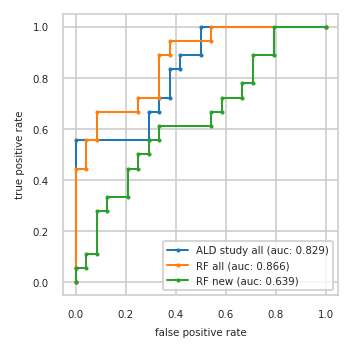

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.000 0.056
2          0.000 0.556  0.000 0.444  0.042 0.056
3          0.292 0.556  0.042 0.444  0.042 0.111
4          0.292 0.667  0.042 0.556  0.083 0.111
5          0.333 0.667  0.083 0.556  0.083 0.278
6          0.333 0.722  0.083 0.667  0.125 0.278
7          0.375 0.722  0.250 0.667  0.125 0.333
8          0.375 0.833  0.250 0.722  0.208 0.333
9          0.417 0.833  0.333 0.722  0.208 0.444
10         0.417 0.889  0.333 0.889  0.250 0.444
11         0.500 0.889  0.375 0.889  0.250 0.500
12         0.500 1.000  0.375 0.944  0.292 0.500
13         1.000 1.000  0.542 0.944  0.292 0.556
14           NaN   NaN  0.542 1.000  0.333 0.556
15           NaN   NaN  1.000 1.000  0.333 0.611
16           NaN   NaN    NaN   NaN  0.542 0.611
17           NaN   NaN    NaN   NaN  0.542 0.667
18           NaN   NaN    NaN   NaN  0.583 0.667
19           NaN   NaN    NaN   NaN  0.583 0.722
20           NaN   NaN    NaN   NaN  0.667 0.722
21           NaN   NaN    NaN   NaN  0.667 0.778
22           NaN   NaN    NaN   NaN  0.708 0.778
23           NaN   NaN    NaN   NaN  0.708 0.889
24           NaN   NaN    NaN   NaN  0.792 0.889
25           NaN   NaN    NaN   NaN  0.792 1.000
26           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,Q14894
1,P31946;P31946-2,C9JIZ6;P07602;P07602-2;P07602-3,E7EPV7;P37840;P37840-2
2,Q9BRA2,F8WE04;P04792,P51688
3,A0A0A0MRJ7;P12259,P10636-2;P10636-6,Q96GD0
4,P61981,P04075,Q9NUQ9
5,C9JF17;P05090,P14174,P31321
6,Q9Y2T3;Q9Y2T3-3,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
7,P04075,Q14894,Q9NS84
8,P14174,P63104,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


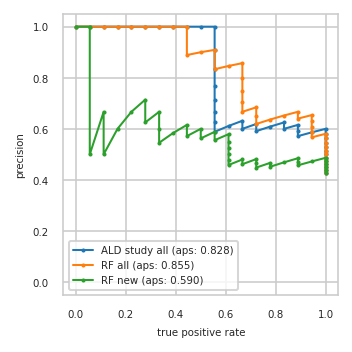

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.448 0.722
14         0.571 0.889     0.607 0.944     0.464 0.722
15         0.593 0.889     0.630 0.944     0.481 0.722
16         0.615 0.889     0.654 0.944     0.462 0.667
17         0.600 0.833     0.640 0.889     0.480 0.667
18         0.625 0.833     0.667 0.889     0.458 0.611
19         0.609 0.778     0.652 0.833     0.478 0.611
20         0.591 0.722     0.636 0.778     0.500 0.611
21         0.619 0.722     0.619 0.722     0.524 0.611
22         0.600 0.667     0.650 0.722     0.550 0.611
23         0.632 0.667     0.684 0.722     0.579 0.611
24         0.611 0.611     0.667 0.667     0.556 0.556
25         0.588 0.556     0.706 0.667     0.588 0.556
26         0.625 0.556     0.750 0.667     0.562 0.500
27         0.667 0.556     0.800 0.667     0.600 0.500
28         0.714 0.556     0.857 0.667     0.571 0.444
29         0.769 0.556     0.846 0.611     0.615 0.444
30         0.833 0.556     0.833 0.556     0.583 0.389
31         0.909 0.556     0.909 0.556     0.545 0.333
32         1.000 0.556     0.900 0.500     0.600 0.333
33         1.000 0.500     0.889 0.444     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.714 0.278
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.500 0.111
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


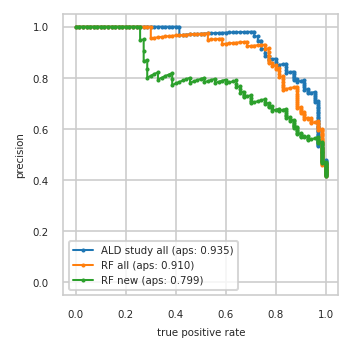

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


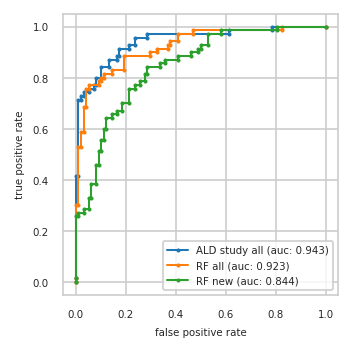

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}